<h2>Classificador SVM e metaheurística Busca Tabu</h2>

Alunos: Everton Thomas, Gustavo Emmel

Inicialmente, vamos fazer os imports necessários:

In [169]:
import pandas as pd
import numpy as np
import random
import copy
import time

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from tqdm import tqdm_notebook as tqdm

<h2>Carregando dataset</h2>

Para testar o algoritmo, utilizamos o <i>dataset</i> [sonnar.all.data](https://www.kaggle.com/ypzhangsam/sonaralldata) que possui dados de varreduras de sonares para identificação de minas.

É um problema de classificação binária, onde o objetivo é classificar cada instância como Rocha ou Mina.

In [184]:
data = pd.read_csv('sonar.all-data.csv', delimiter=',', header=None)

data.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


Inicialmente dividiremos o <i>dataset</i> em treino (80%) e teste (20%), e aplicamos um classificador SVM com parâmetros arbitrários e validação cruzada (10 folds).

Isso nos permite ter um <i>score</i> inicial para comparar com nossa metaheurístca de seleção de parâmetros.

Com o objetivo de organizar o código, criamos uma rotina própria de validação cruzada que retorna o <i>score</i> médio de treino e teste.

In [5]:
def cross_validate(model, X, y, n_folds):
    score = {'fit_score': [], 'test_score': []}
    
    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=10)
    
    for train, test in kf.split(X, y):
        X_train, y_train = X[train, :], y[train]
        X_test, y_test = X[test, :], y[test]
        
        model.fit(X_train, y_train)
        
        pred_train_y = model.predict(X_train)
        
        pred_test_y = model.predict(X_test)
        
        score['fit_score'].append(accuracy_score(y_train, pred_train_y))
        score['test_score'].append(accuracy_score(y_test, pred_test_y))
    return score

Aqui a divisão do <i>dataset</i> e aplicação do SVM com C = 10 e gamma = 0.01

In [6]:
train, test = train_test_split(data.get_values(), test_size=0.2)

model = SVC(C=10.0, gamma=0.01)

score = cross_validate(model, train[:,:-1], train[:,-1], n_folds=10)

Utilizando os parâmetros arbitrários (C=10 e gamma=0.01) obtivemos os seguintes valores de acurácia:

In [7]:
"Mean accuracy on fit: {} / Mean accuracy on test {}".format(np.mean(score['fit_score']), np.mean(score['test_score']))

'Mean accuracy on fit: 0.809275167785235 / Mean accuracy on test 0.7055147058823529'

<h2>Implementação metaheurística Tabu List</h2>

Como passo inicial, criamos um método para geração de vizinhança, que é um requisito básico da metaheurística Tabu List.

Este método, ao receber a posição inicial (current) e o número de vizinhos a ser gerado (n), entrega um <i>array</i> contendo a vizinhança gerada.

A estratégia utilizada para geração da respectiva vizinhança passa pela escolha aleatória em três partes:
    - Quais dos parâmetros (C e/ou gamma) serão alterados, baseado na posição inicial (current);
    - Qual a direção da alteração: positiva ou negativa
    - Escolha aleatória do valor dentro de um <i>range</i> pré-estabelecido para o parâmetro que está sendo alterado
    

O <i>range</i> de variação definido para os parâmetros são:
    - C: 1 à 1000
    - gamma: 0.01 à 0.1
    
Além disso, para que os valores encontrados para os parâmetros de um novo vizinho não ficassem muito distante da solução inicial, optamos por utilizar duas funções para delimitar o fator de ajuste:
    - C: função raiz
    - gamma: função quadrática

Os gráficos abaixo demonstram a máxima variação para os parâmetros que podem ser obtidos, com base no <i>range</i> definido para cada um dos parâmetros.

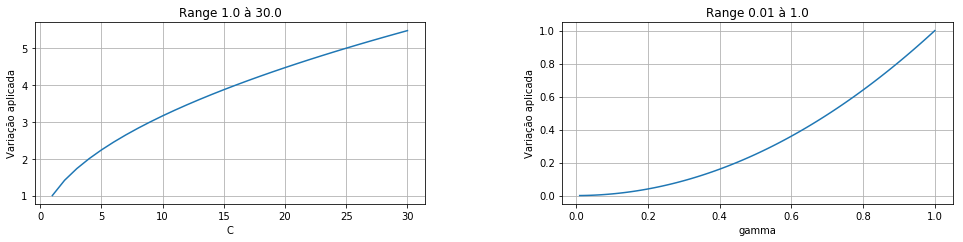

In [187]:
C = np.arange(1.,31., 1)
gamma = np.arange(0.01,1.01,.01)

plt.figure(figsize=(15, 3))
plt.subplot(121)
plt.plot(C, C**(1/2))
plt.title('Range {} à {}'.format(min(C), max(C)))
plt.xlabel('C')
plt.ylabel('Variação aplicada')
plt.grid(True)

plt.subplot(122)
plt.title('Range {} à {}'.format(min(gamma), max(gamma)))
plt.xlabel('gamma')
plt.ylabel('Variação aplicada')
plt.grid(True)
plt.plot(gamma, gamma**2)

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

In [171]:
params_var   = {'C':[1.,30.], 'gamma':[0.01,1.01]}

def generate_neighbours(current, n):
    """
    Geração da vizinhança para uma solução.
    
    Parâmetros
        current: solução atual
        n......: número de vizinhos que serão gerados
    """
    neighbourhood = []
    params = ['C','gamma']
    params_func = {'C': (lambda x: x**(1/2)), 'gamma': (lambda x: x**2)}
    operations = ['+','-']
    
    for i in range(n):
        
        new_par = current.copy()
        
        random.seed(i)
        
        while True:
        
            tabu = ''
        
            for p in params:

                if np.random.randint(0,2) == 1:
                    
                    random.seed(i * 7)
                    
                    while True:
                        op = random.choice(operations)
                        
                        #Fator de ajuste
                        factor = np.random.uniform(low=params_var[p][0], high=params_var[p][1])

                        if op == '-':
                            factor = params_func[p](factor) * -1
                        else:
                            factor = params_func[p](factor)
                       
                        new_value = new_par[p] + factor

                        if new_value >= params_var[p][0] and new_value <= params_var[p][1]:
                            new_par[p] = np.round(new_value, 2)
                            tabu = tabu + '1' + ('-1' if op == '-' else '1')
                            break
                            
                else:
                    tabu = tabu + '00'

            if new_par not in neighbourhood:
                new_par['tabu'] = tabu
                neighbourhood.append(new_par)
                break
        
    return neighbourhood

A estrutura de um vizinho é composta pelo parâmetro C e gamma, e seus respectivos valores. Além disso, incluímos uma outra estrutura para indicar qual(is) o(s) parâmetro(s) e direção foram modificados em relação a solução corrente.

Essa última será utilizada posteriormente na lista tabu, para indicar movimentos proibitivos.

Esse é um exemplo de um vizinho gerado pelo método <i>generate_neighbours</i>:
    
    {'C':1., 'gamma':0.08, 'tabu': '1011'}
    
Os atributos C e gamma referem-se aos valores setados para esse vizinho. Já o atributo 'tabu' indica que o parâmetro C foi alterado negativamente (valor menor que o valor de C da solução corrente), e que o <i>gamma</i> também foi alterado, porém positivamente (valor maior que o valor de <i>gamma</i> da solução corrente)

Para selecionar a melhor solução na vizinhança gerada, criamos um método chamado <i>find_neighbour</i> que avalia a acurácia para cada uma dessas soluções em um modelo de validação cruzada de 10-folds, utilizando os atributos C e <i>gamma</i> da solução como parâmetros para o modelo.

A melhor acurácia encontrada é então selecionada como a melhor solução dentro da vizinhança.

In [9]:
def find_neighbour(X, y, neighborhood):
    """
    Encontra o melhor entre a vizinhança, baseado na acurácia
    
    Parâmetros
        X...........: Valores do dataset
        y...........: Labels do dataset
        neighborhood: vizinhança que será avaliada
    """
    folds = 10
    
    best_neighbour = None
    
    for neighbor in neighborhood:
        model = SVC(C = neighbor['C'], gamma=neighbor['gamma'])
        neighbor_score = cross_validate(model, X, y, n_folds=folds)
        
        if best_neighbour == None or best_neighbour_score < np.mean(neighbor_score['test_score']):
            best_neighbour = neighbor
            best_neighbour_score = np.mean(neighbor_score['test_score'])

    return best_neighbour, best_neighbour_score

<h2>A Lista Tabu</h2>

Agora vamos para a característica que dá nome à esta metaheurística: a <b>lista tabu</b>.

A lista tabu é composta por <b>movimentos</b> que não são permitidos no espaço de busca. Repare que não falamos de valores não permitidos, mas sim de movimentos não permitidos. No presente caso, avaliamos que um movimento será caracterizado pelos parâmetros alterados na solução avaliada em relação a solução corrente, e a direção dessa alteração: negativa ou positiva.

Supondo o seguinte cenário:
    - Solução corrente: {'C': 10., 'gamma':0.05, 'tabu': '1000'}

Caso o movimento '1000', esteja presente na lista tabu, esta solução não poderá ser adotada, mesmo que possua uma acurácia superior. Essa abordagem força o algoritmo a tentar encontrar outras soluções, permitindo diversificar a procura no espaço de busca.

Outro mecanismo que adotamos para gerenciamento da lista tabu, é um contador de iterações. Cada movimento presente na lista recebe um valor <i>n</i> ao ser alocado - neste caso 3, e a cada consulta na lista tabu, esse contador é decrementado (<i>n</i> - 1). Quando um movimento possuir o valor 0 (zero) neste contador, ele é imediatamente retirado na lista tabu. Desta forma, permitimos uma diversificação ainda maior na busca.

Este é um exemplo da lista tabu e de seus itens:
  
    [
        {'tabu': '0000', 'cnt': 1}, 
        {'tabu': '111-1', 'cnt': 2}, 
        {'tabu': '1100', 'cnt': 3}
    ]

O exemplo anterior demonstra a existência de 3 movimentos diferente na lista tabu, sendo que o primeiro já está na lista a 3 iterações e na próxima será removido. Isso permite que, caso o algoritmo encontre uma solução com <i>score</i> superior, mas com o mesmo movimento ('0000'), essa solução possa ser alocada a lista tabu novamente.

In [75]:
def check_tabu_list(solution, tabu_list):
    cnt = 3
    
    for x in tabu_list:
        x['cnt'] = x['cnt'] - 1
        if x['cnt'] <= 0:
            tabu_list.remove(x)
    
    tabu_item = [i for i in tabu_list if i['tabu'] == solution['tabu']]
    
    if not tabu_item:
        new_tabu = { 'tabu': solution['tabu'], 'cnt': cnt}
        tabu_list.append(new_tabu)
        return True
    
    return False

O método <i>check_tabu_list</i> verifica e atualiza a lista tabu.

Inicialmente, este método subtrai 1 (um) de cada elemento presente na lista, atualizando o contador de iterações. Aqueles que após essa atualização possuirem o valor 0 (zero) no contador são retirados da lista.

O próximo passo verifica se o movimento que determinou a solução já está presente na lista tabu. Caso esteja, a solução é rejeitada ou, se a solução não foi encontrada, então é inserida.

<h2>Testando metaheurística Busca Tabu</h2>

Inicialmente informamos ao algoritmo nossa configuração de ponto de partida. Para isso, escolhemos arbitrariamente os valores:

    C: 1.0, gamma: 0.01
    
Aplicamos esses parâmetros para o classificador SVM a aferimos o <i>score</i> obtido.

In [173]:
current = {'C': 1.0, 'gamma': 0.01, 'tabu': '0000'}

model = SVC(C = current['C'], gamma=current['gamma'])

current_score = cross_validate(model, train[:,:-1], train[:,-1], n_folds=10)

print("Current params {}".format(current))

print("FIT >> Mean accuracy train set {} / Mean accuracy test set {}".format(np.mean(current_score['fit_score']), np.mean(current_score['test_score'])))

predicted = model.predict(test[:,:-1])

accuracy = accuracy_score(test[:,-1], predicted)

print("TEST >> Accuracy test set {}".format(accuracy))

Current params {'C': 1.0, 'gamma': 0.01, 'tabu': '0000'}
FIT >> Mean accuracy train set 0.5421744966442953 / Mean accuracy test set 0.5426470588235294
TEST >> Accuracy test set 0.5


Percebemos que os valores para C e <i>gamma</i> que escolhemos não foram boas opções, já que nos dados de validação do modelo obtivemos acurácia de 0.5.

Então vamos ver se nossa metaheurística consegue melhorar isso. Vamos assumir que esta configuração é nossa melhor solução até o momento, e vamos adicioná-la na <b>lista tabu</b>.

In [174]:
best_solution = current
best_score = np.mean(current_score['test_score'])

tabu_list = list()

_ = check_tabu_list(best_solution, tabu_list)

Para nosso teste utilizaremos 30 (trinta) iterações para busca da melhor solução e a cada iteração uma vizinhança de 25 (vinte e cinco) soluções será gerada para avaliação.

In [175]:
start_time = time.time()

iterator = 30
n_neighbors = 25

with tqdm(total=iterator) as pbar:
    
    for i in range(0,iterator):
        neighbourhood = generate_neighbours(current,n_neighbors)
        
        best_neighbour, best_neighbour_score = find_neighbour(train[:,:-1], train[:,-1], neighbourhood)

        if best_neighbour_score >= best_score and check_tabu_list(best_neighbour, tabu_list):
            current = best_neighbour
            best_solution = best_neighbour
            best_score = best_neighbour_score
        
        current = best_neighbour

        pbar.update(1)

end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time))
print('Best solution: {} / Best score: {}'.format(best_solution, best_score))

HBox(children=(IntProgress(value=0, max=30), HTML(value='')))


--- 32.09929299354553 seconds ---
Best solution: {'C': 12.51, 'gamma': 0.36, 'tabu': '0000'} / Best score: 0.8797794117647058


Agora vamos aplicar a melhor solução encontrada por nossa metaheurística sobre os dados de validação, ou seja, os 20% que reservamos do dataset inicial.

In [176]:
model = SVC(C = best_solution['C'], gamma=best_solution['gamma'])

current_score = cross_validate(model, train[:,:-1], train[:,-1], n_folds=10)

print("FIT >> Mean accuracy train set {} / Mean accuracy test set {}".format(np.mean(current_score['fit_score']), np.mean(current_score['test_score'])))

predicted = model.predict(test[:,:-1])

accuracy = accuracy_score(test[:,-1], predicted)

print("TEST >> Accuracy test set {}".format(accuracy))

FIT >> Mean accuracy train set 1.0 / Mean accuracy test set 0.8797794117647058
TEST >> Accuracy test set 0.9285714285714286


<h2>Resultado</h2>

A metaheurística Busca Tabu aqui implementada, para o presente caso, possibilitou encontrar um <i>set</i> de parâmetros para um classificador SVM que possibilitou alcançar uma acurácia de ~0.92, com um tempo de execução de ~32.0 segundos em um Notebook i7 16GB RAM.

<h2>Comparativo com Grid Search</h2>

Para efeitos de comparação, vamos executar uma busca exaustiva utilizando GridSearch, na implementação do SciKit.

Definimos um método para o qual passamos os dados, os labels e o número de <i>folds</i> e este retorna a melhor configuração encontrada. Manteremos a mesma configuração utilizada em nosso teste com a Busca Tabu, ou seja, o mesmos parâmetros do SVM, o mesmo <i>range</i> de valores para ambos e 10 <i>folds</i>.

In [178]:
#Teste com GridSearch
from sklearn.model_selection import GridSearchCV

def svc_param_selection(X, y, nfolds):
    Cs = np.arange(1,30, 1)
    gammas = np.arange(0.01, 1., 0.01)
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [180]:
start_time = time.time()
param_sel = svc_param_selection(train[:,:-1], train[:,-1], 10)
end_time = time.time()

print("--- %s seconds ---" % (end_time - start_time))
print('Best solution GridSearch: {}'.format(param_sel))

--- 150.2852590084076 seconds ---
Best solution GridSearch: {'C': 13, 'gamma': 0.33}


Após testar exaustivamente todas as possibilidades, o método GridSearch encontrou a configuração (C = 13 e gamma = 0.33). 

Agora aplicamos os parâmetros encontrados sobre os dados de validação:

In [181]:
model = SVC(C = param_sel['C'], gamma=param_sel['gamma'])

current_score = cross_validate(model, train[:,:-1], train[:,-1], n_folds=10)

print("Current params {}".format(param_sel))

print("FIT >> Mean accuracy train set {} / Mean accuracy test set {}".format(np.mean(current_score['fit_score']), np.mean(current_score['test_score'])))

predicted = model.predict(test[:,:-1])

accuracy = accuracy_score(test[:,-1], predicted)

print("TEST >> Accuracy test set {}".format(accuracy))

Current params {'C': 13, 'gamma': 0.33}
FIT >> Mean accuracy train set 1.0 / Mean accuracy test set 0.8735294117647058
TEST >> Accuracy test set 0.9285714285714286


Apesar da acurácia sobre os dados de validação ser praticamente a mesma entre GridSearch e Busca Tabu, <b>o primeiro dispendeu 5x mais tempo (~150.28 segundos)</b> quando comparado ao cenário que utilizou somente a metaheurística, para a mesma configuração de computador (i7 16GB RAM).

<h2>Conclusão</h2>

Concluímos que, para o cenário atual, a utilização da metaheurística Busca Tabu superou o uso do método GridSearch da biblioteca SciKit, não pela acurácia, mas sim pelo tempo necessário para busca da melhor configuração.